# Get the MNIST data

In [1]:
from common import get_mnist

mnist = get_mnist()

xtrain = mnist['x']['train']
xtest = mnist['x']['test']
xval = mnist['x']['val']

ytrain = mnist['y']['train']
ytest = mnist['y']['test']
yval = mnist['y']['val']

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Preprocessing

Let's:
* Reshape the input values to by (28,28) instead of (784,).
* Standardize the input values

In [2]:
xtrain = xtrain.reshape((55000,28,28,1))
xtest = xtest.reshape((xtest.shape[0], 28, 28, 1))
xval = xval.reshape((5000,28,28,1))

xtrain = (xtrain - xtrain.mean()) / xtrain.std()
xtest = (xtest - xtest.mean()) / xtest.std()
xval = (xval - xval.mean()) / xval.std()

# Model Architecture

The previous model was IN-CN-MP-FC. This first one will just add another convolutional layer.

***Model selection:*** In the previous couple of iterations, I tuned parameters of the model and evaluated at the end of each training run based on the validation data. Instead, I'm now going to evaluate models based on the testing data and do a final evaluation on the validation data. It may be difficult to achieve similar accuracies on the validation set since I probably overfit to that last time.

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
# config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD

Based on a successful model [here](http://yann.lecun.com/exdb/mnist/), I tried a 1-20-40-60-80-100-120-120-10 model and it froze. I also tried a large/deep network and it didn't seem to do very well, so I'm going back to the 20-40-250 model and trying AveragePooling2D instead of MaxPooling2D.

Train on 55000 samples, validate on 10000 samples
Epoch 1/30
55000/55000 [==============================] - 11s 193us/step - loss: 0.5191 - acc: 0.8398 - val_loss: 0.1283 - val_acc: 0.9580
Epoch 2/30
55000/55000 [==============================] - 8s 147us/step - loss: 0.1168 - acc: 0.9640 - val_loss: 0.0705 - val_acc: 0.9758
Epoch 3/30
55000/55000 [==============================] - 8s 147us/step - loss: 0.0791 - acc: 0.9751 - val_loss: 0.0664 - val_acc: 0.9779
Epoch 4/30
55000/55000 [==============================] - 8s 146us/step - loss: 0.0623 - acc: 0.9797 - val_loss: 0.0462 - val_acc: 0.9839
Epoch 5/30
55000/55000 [==============================] - 8s 146us/step - loss: 0.0504 - acc: 0.9839 - val_loss: 0.0406 - val_acc: 0.9864
Epoch 6/30
55000/55000 [==============================] - 8s 146us/step - loss: 0.0439 - acc: 0.9860 - val_loss: 0.0386 - val_acc: 0.9867
Epoch 7/30
55000/55000 [==============================] - 8s 146us/step - loss: 0.0369 - acc: 0.9887 - val_loss: 0.0336 -

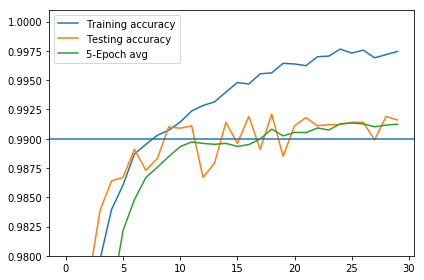

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_keras_history(h=None):
    e = h.epoch
    h = h.history
    f, ax = plt.subplots()
    ax.plot(e, h['acc'], label='Training accuracy')
    ax.plot(e, h['val_acc'], label='Testing accuracy')
    ax.legend()
    plt.tight_layout()
    return ax

convolutional = Sequential()

convolutional.add(
    Conv2D(
        input_shape=(28,28,1),
        filters=20,
        kernel_size=(14,14),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
        # TODO: Regularizers
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(
    Conv2D(
        filters=40,
        kernel_size=(7,7),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
        # TODO: Regularizers
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(
    Conv2D(
        filters=150,
        kernel_size=(4,4),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
        # TODO: Regularizers
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(Flatten())

convolutional.add(
    Dense(10,
          activation='softmax',
#           kernel_regularizer=l2(0.00000000001),
#           activity_regularizer=l2(0.0000000001)
         )
)

# optimizer = SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)

convolutional.compile(
    optimizer='adam', # (SGD | Adagrad) | Adadelta | (RMSprop | Adam | Adamax | Nadam)
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

h = convolutional.fit(xtrain, ytrain, shuffle=True, epochs=30, batch_size=500, validation_data=(xtest,ytest))

ax = plot_keras_history(h)
avg = pd.Series(h.history['val_acc']).rolling(5).mean().reindex(h.epoch)
ax.plot(avg, label='5-Epoch avg')
ax.legend()
ax.set_ylim([0.98,1.001])
ax.axhline(0.99)
plt.tight_layout()

In [6]:
convolutional.evaluate(xval, yval)

5000/5000 [==============================] - 1s 167us/step


[0.028337481941964143, 0.9932]